In [1]:
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torchvision import datasets, transforms

# Data preparation



In [2]:
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt

#define dataset for img and mask
file_dir = "/content/drive/MyDrive/ColabGitHub/ISIC2018_Task1-2_Training_Data"
os.chdir(file_dir)

In [4]:
from torchvision import datasets
from torchvision.datasets import  ImageFolder
from torch.utils.data import dataloader, random_split, Subset
from torchvision.transforms import transforms

In [5]:
from torch.utils.data import Dataset
from PIL import Image

class Unet_dataset(Dataset):
  def __init__(self,
               img_dir = './ISIC2018_Task1-2_Training_Input_x2',
               mask_dir = './ISIC2018_Task1_Training_GroundTruth_x2', 
               img_transforms=None,
               mask_transforms= None):
    
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_transforms = img_transforms
    self.mask_transforms = mask_transforms

    self.imgs = [file for file in sorted(os.listdir(self.img_dir)) if file.endswith('.jpg')]
    self.masks = [file for file in sorted(os.listdir(self.mask_dir)) if file.endswith('.png')]

  #meke dataloader
  def load_data(self, idx):
    img_path = os.path.join(self.img_dir, self.imgs[idx])
    mask_path = os.path.join(self.mask_dir, self.masks[idx])
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    return img, mask

  def __getitem__(self, idx):
    img, mask = self.load_data(idx)
    #transformation
    if self.img_transforms is not None:
      img = self.img_transforms(img)
    if self.mask_transforms is not None:
      mask = self.mask_transforms(mask)
    return img, mask

  def __len__(self):
    return len(self.imgs)

In [6]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


#transformation
img_tfs = transforms.Compose([
                                 transforms.Resize((128,128)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
                                 ]
                                )

mask_tfs = transforms.Compose([
                                 transforms.Resize((128,128)),
                                 transforms.ToTensor(),
                                 ]
                                )

dataset = Unet_dataset(img_transforms=img_tfs, mask_transforms=mask_tfs)


#shuffle index
sample_size = len(dataset.imgs)
train_size = int(sample_size*0.8)
test_size = sample_size - train_size

#train and test set
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(123))

#dataloader
train_loader= DataLoader(train_set, batch_size=64, shuffle = True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

# Improved Unet

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Context(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Context, self).__init__()
    self.context = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.Dropout2d(p=0.3),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = 1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )

  def forward(self, x):
    x = self.context(x) + x
    return x


class Localization(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Localization, self).__init__()
    self.localization = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )
    
  def forward(self, x):
    return self.localization(x)


class Upsampling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Upsampling, self).__init__()
    self.upsampling = nn.Sequential(
                            nn.Upsample(scale_factor=2, mode='nearest'),
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )
    
  def forward(self, x):
    return self.upsampling(x)


class Segment(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Segment, self).__init__()
    self.segment = nn.Sequential(
                              nn.Conv2d(in_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False),
                              nn.BatchNorm2d(out_channels),
                              nn.LeakyReLU(negative_slope=0.02, inplace=True)
                              )
    
  def forward(self, x):
    return self.segment(x)


class Conv2(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Conv2, self).__init__()
    self.conv2 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )

  def forward(self, x):
    return self.conv2(x)


class ImprovedUnet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, feature_size=[16, 32, 64, 128]):
    super(ImprovedUnet, self).__init__()
    self.Conv1 = nn.Conv2d(in_channels=3, out_channels=feature_size[0], kernel_size=3, stride=1, padding=1, bias=False)                 
    self.Downs = nn.ModuleList()
    self.Convs = nn.ModuleList()
    self.Ups = nn.ModuleList()
    self.Segmentations = nn.ModuleList()

    self.upscale = nn.Upsample(scale_factor=2, mode='nearest')
    self.bottleneck = Context(feature_size[-1]*2, feature_size[-1]*2)


    #Downsampling frame
    for feature in feature_size:
      self.Downs.append(Context(feature, feature))
      self.Convs.append(Conv2(feature, feature*2))

    #Upsampleing frame
    for feature in reversed(feature_size):
      #Upsample
      self.Ups.append(Upsampling(feature*2, feature))

      #Localization
      if feature != feature_size[0]:
        self.Ups.append(Localization(feature*2,  feature))
      else:
        self.Ups.append(Localization(feature*2,  feature*2))
            
      #Segmentation
      self.Segmentations.append(Segment(feature, 1))

    self.final_conv = nn.Conv2d(feature_size[0]*2, out_channels, kernel_size=1, stride=1, bias=False)
                      

  def forward(self, x):
    skip_connections = []
    segmentation_layers = []

    x = self.Conv1(x)

    #Downsampling steps
    for i, (context_i, conv_i) in enumerate(zip(self.Downs, self.Convs)):
      x = context_i(x)
      #preserve location
      skip_connections.append(x)
      x = conv_i(x)

    x = self.bottleneck(x) + x
    skip_connections = skip_connections[: : -1]

    #Upsampling steps
    for idx in range(0, len(self.Ups), 2):
      #upsample
      x = self.Ups[idx](x)

      #localization
      skip_connection = skip_connections[idx//2]
      concatnate_skip = torch.cat((skip_connection, x), dim=1)
      x = self.Ups[idx+1](concatnate_skip)

      #segmentation
      if idx == 2 or idx == 4:
        x_segment = self.Segmentations[idx//2](x)
        segmentation_layers.append(x_segment)

    seg_scale1 = self.upscale(segmentation_layers[0])
    seg_scale2 = self.upscale(segmentation_layers[1]+seg_scale1)

    x = self.final_conv(x)
    x = x + seg_scale2

    output =  F.sigmoid(x)
    
    return output

In [9]:
feature_size=[16, 32, 64, 128]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
#dice coef
def dice_coef(pred, target):
  batch_size = len(pred)
  somooth = 1.

  pred_flat = pred.view(batch_size, -1)
  target_flat = target.view(batch_size, -1)

  intersection = (pred_flat*target_flat).sum()
  dice_coef = (2.*intersection+somooth)/(pred_flat.sum()+target_flat.sum()+somooth)
  return dice_coef

#loss
def dice_loss(pred, target):
  dice_loss = 1 - dice_coef(pred, target)
  return dice_loss

In [11]:
import torch.optim as optim

#set parameters
feature_size=[16, 32, 64, 128]
model =  ImprovedUnet(feature_size=feature_size)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50

In [ ]:
from tqdm import tqdm

TRAIN_LOSS = []
TRAIN_DICE = []
TEST_LOSS =[]
TEST_DICE = []

for epoch in range(1, EPOCHS+1):
  print('EPOCH {}/{}'.format(epoch, EPOCHS))
  running_loss = 0
  running_dicecoef = 0
  running_loss_test = 0
  running_dicecoef_test = 0
  BATCH_NUM = len(train_loader)
  BATCH_NUM_TEST = len(test_loader)

  #training
  with tqdm(train_loader, unit='batch') as tbatch:
    for batch_idx, (x, y) in enumerate(tbatch):
      x, y = x.to(device), y.to(device)
      tbatch.set_description(f'Batch: {batch_idx}')

      optimizer.zero_grad()
      output = model(x)
      loss = dice_loss(output, y)
      dicecoef = dice_coef(output, y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_dicecoef += dicecoef.item()

      tbatch.set_postfix(loss=loss.item(), dice_coef=dicecoef.item())

  epoch_loss = running_loss/BATCH_NUM
  epoch_dicecoef = running_dicecoef/BATCH_NUM
  TRAIN_LOSS.append(epoch_loss)
  TRAIN_DICE.append(epoch_dicecoef)

  #test
  with tqdm(test_loader, unit='batch') as tsbatch:
    for batch_idx, (x, y) in enumerate(tsbatch):
      x, y = x.to(device), y.to(device)
      tsbatch.set_description(f'Batch: {batch_idx}')
      output_test = model(x)
      loss_test = dice_loss(output_test, y)
      dicecoef_test = dice_coef(output_test, y)
      tsbatch.set_postfix(loss=loss_test.item(), dice_coef=dicecoef_test.item())

      running_loss_test += loss_test.item()
      running_dicecoef_test += dicecoef_test.item()

  TEST_LOSS.append(running_loss_test/BATCH_NUM_TEST)
  TEST_DICE.append(running_dicecoef_test/BATCH_NUM_TEST)

EPOCH 1/50


Batch: 0:   0%|          | 0/33 [00:05<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.639, loss=0.361]


EPOCH 2/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.711, loss=0.289]


EPOCH 3/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.777, loss=0.223]


EPOCH 4/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.821, loss=0.179]


EPOCH 5/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.853, loss=0.147]


EPOCH 6/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.846, loss=0.154]


EPOCH 7/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.847, loss=0.153]


EPOCH 8/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.862, loss=0.138]


EPOCH 9/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.874, loss=0.126]


EPOCH 10/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.86s/batch, dice_coef=0.825, loss=0.175]


EPOCH 11/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.847, loss=0.153]


EPOCH 12/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.882, loss=0.118]


EPOCH 13/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.87s/batch, dice_coef=0.878, loss=0.122]


EPOCH 14/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.892, loss=0.108]


EPOCH 15/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.882, loss=0.118]


EPOCH 16/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.844, loss=0.156]


EPOCH 17/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.87s/batch, dice_coef=0.893, loss=0.107]


EPOCH 18/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.875, loss=0.125]


EPOCH 19/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.877, loss=0.123]


EPOCH 20/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.896, loss=0.104]


EPOCH 21/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.889, loss=0.111]


EPOCH 22/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.876, loss=0.124]


EPOCH 23/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.87s/batch, dice_coef=0.886, loss=0.114]


EPOCH 24/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.901, loss=0.0992]


EPOCH 25/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.875, loss=0.125]


EPOCH 26/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.897, loss=0.103]


EPOCH 27/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.852, loss=0.148]


EPOCH 28/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.882, loss=0.118]


EPOCH 29/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.862, loss=0.138]


EPOCH 30/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.875, loss=0.125]


EPOCH 31/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.909, loss=0.0913]


EPOCH 32/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.888, loss=0.112]


EPOCH 33/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.87, loss=0.13]


EPOCH 34/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.879, loss=0.121]


EPOCH 35/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.907, loss=0.0927]


EPOCH 36/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.873, loss=0.127]


EPOCH 37/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.876, loss=0.124]


EPOCH 38/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.87s/batch, dice_coef=0.868, loss=0.132]


EPOCH 39/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.871, loss=0.129]


EPOCH 40/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.863, loss=0.137]


EPOCH 41/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.84s/batch, dice_coef=0.869, loss=0.131]


EPOCH 42/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.871, loss=0.129]


EPOCH 43/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.86s/batch, dice_coef=0.846, loss=0.154]


EPOCH 44/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.831, loss=0.169]


EPOCH 45/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.864, loss=0.136]


EPOCH 46/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.83s/batch, dice_coef=0.865, loss=0.135]


EPOCH 47/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.873, loss=0.127]


EPOCH 48/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.86s/batch, dice_coef=0.88, loss=0.12]


EPOCH 49/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.85s/batch, dice_coef=0.869, loss=0.131]


EPOCH 50/50


Batch: 8: 100%|██████████| 9/9 [00:34<00:00,  3.82s/batch, dice_coef=0.882, loss=0.118]


In [ ]:
!apt-get install graphviz
!pip install torchviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
from torchviz import make_dot
make_dot(output, params=dict(model.named_parameters(), ))

In [ ]:
#save model
filename = "Unet_ISIC2.pth"
torch.save(model.state_dict(), filename)

In [ ]:
model.eval()
p = model(x)[0]
p = p.to('cpu')
plt.imshow(p.detach().squeeze(), cmap='gray')

#Evaluation

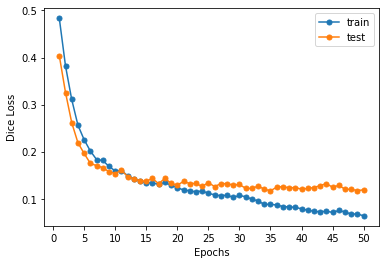

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(1,EPOCHS+1)
X_tick = np.arange(0,EPOCHS+1,5)

plt.plot(X, TRAIN_LOSS, marker='.', markersize=10, label='train')
plt.plot(X, TEST_LOSS, marker='.', markersize=10, label='test')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.xticks(X_tick)
plt.legend()
plt.show()

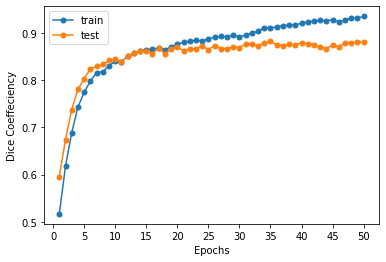

In [ ]:
plt.plot(X, TRAIN_DICE, marker='.', markersize=10, label='train')
plt.plot(X, TEST_DICE, marker='.', markersize=10, label='test')
plt.xlabel('Epochs')
plt.ylabel('Dice Coeffecient')
plt.xticks(X_tick)
plt.legend()
plt.show()

# Segmentation

In [137]:
#load model
new_model = ImprovedUnet(feature_size=feature_size)

filename = "Unet_ISIC2.pth"
checkpoint = torch.load(filename)

new_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [138]:
for batch in test_loader:
  x, y = batch
  print(x.shape, y.shape)
  break

torch.Size([64, 3, 128, 128]) torch.Size([64, 1, 128, 128])


In [139]:
p = new_model(x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [140]:
def segment_pred_mask(imgs=x, pred_masks=p, idx=0, alpha=10):
  seg_img = x[idx].clone()
  image_r = seg_img[0] #C: red
  image_r = image_r*(1-alpha*p[idx])+(p[idx]*p[idx]*alpha)
  segment_image = image_r.detach().squeeze()
  seg_img[0] = segment_image
  return seg_img

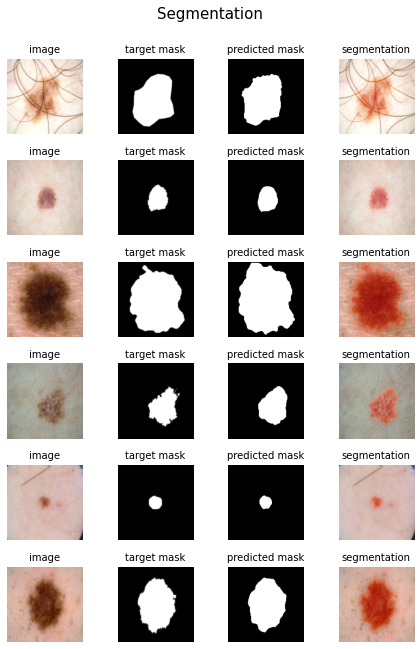

In [141]:
#visualise
import matplotlib.pyplot as plt

n_col = 4
n_row = 6

def plot_gallery(images=x, mask=y, pred_mask = p, n_row=n_row, n_col=n_col):
  idxs = n_col*n_row
  plt.figure(figsize=(1.5*n_col, 1.5*n_row))
  plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35) #adjust layout parameters
  plt.suptitle('Segmentation', fontsize=15)

  for i in range(0, idxs, 4):
    #image
    plt.subplot(n_row, n_col,  i+1)
    plt.imshow(x[i].permute(1,2,0))
    plt.title('image', fontsize = 10)
    plt.axis('off')

    #target mask
    plt.subplot(n_row, n_col,  i+2)
    plt.imshow(y[i].detach().squeeze(), cmap='gray')
    plt.title('target mask', fontsize = 10)
    plt.axis('off')
    
    #predicted mask
    plt.subplot(n_row, n_col,  i+3)
    plt.imshow(p[i].detach().squeeze(), cmap='gray')
    plt.title('predicted mask', fontsize = 10)
    plt.axis('off')

    #segmentation
    seg_img = segment_pred_mask(imgs=x, pred_masks=p, idx=i, alpha=0.5)
    plt.subplot(n_row, n_col,  i+4)
    plt.imshow(seg_img.permute(1,2,0))
    plt.title('segmentation', fontsize = 10)
    plt.axis('off')

plot_gallery()
plt.show()

In [142]:
seg_img= segment_pred_mask(imgs=x, pred_masks=p, idx=10, alpha=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


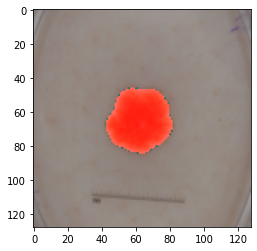

In [143]:
plt.imshow(seg_img.permute(1,2,0))

In [ ]:
print(torch.__version__)

1.9.0+cu111


In [ ]:
!python --version

Python 3.7.12


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3a7e6110-e668-9d4e-bb61-02d20470e114)
